In [ ]:
"""
Author: Eric Korman -> Cofounder/CSO @ Striveworks
"""

# Attention and Transformers

## Imports and helper functions

In [1]:
import math
from itertools import product
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
def smooth(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

In [3]:
def compute_accuracy(dset):
    dl = DataLoader(dset, batch_size=32)
    all_preds, all_labels = [], []
    for x, y in tqdm(dl):
        all_preds.extend(model(x).argmax(1).cpu().numpy().tolist())
        all_labels.extend(y.cpu().numpy().tolist())
    
    return (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)

## Basic mechanism

The attention mechanism operates on sequences (or really sets) of vectors. Let $\mathbb{R}^{L \times d}$ denote the space of length $L$ sequences of vectors in $\mathbb R^d$. For $v \in \mathbb{R}^{L \times d}$ we denote the sequence as $(v_1, \ldots, v_L), ~~ v_i \in \mathbb R^d$.

The basic attention mechanism is the map
$$
\operatorname{att} : \mathbb{R}^{L_1 \times d_1} \times \mathbb{R}^{L_2 \times d_1} \times \mathbb{R}^{L_2 \times d_2} \to \mathbb{R}^{L_1 \times d_2}
$$
defined by
$$
[\operatorname{att}(q, k, v)]_i = \sum_j \alpha_{ij}(q, k) v_j
$$
where
$$
\alpha_{ij}(q, k) = \operatorname{softmax}\left(\frac{q_i \cdot k_1}{\sqrt d_1}, \ldots, \frac{q_i \cdot k_{L_2}}{\sqrt d_1}\right)_j.
$$

In words, $\alpha_{ij}$ is the similarity between the ith element of the first sequence and the jth element of the second (normalized via softmax across the second sequence). The result of attention at index $i$ is then a weighted sum of all of the elements of $v$, weighted so that $v_j$ is favored if the similarity between $q_i$ and $k_j$ is large.

### Bibliography
This type of mechanism was first introduced in:

Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio. ***Neural machine translation by jointly learning to align and translate.*** ICLR 2015.

### PyTorch implementation

In [4]:
def alpha(q, k):
    """ Computes pairwise (in a batch) normalized inner products between Q and K.
    
    Parameters
    ----------
    q : torch.Tensor
        shape [N, L1, DK] where N is the batch size
    k : torch.Tensor
        shape [N, L2, DK]
    
    Returns
    -------
    torch.Tensor
        shape [N, L1, L2]
    """
    alpha = torch.einsum("nik,njk->nij", q, k) / q.shape[-1]**(1/2)
    alpha = F.softmax(alpha, dim=-1)
    return alpha

def attention(q, k, v):
    """ scalar dot product attention
    
    Parameters
    ----------
    q : torch.Tensor
        shape [N, L1, DK] where N is the batch size
    k : torch.Tensor
        shape [N, L2, DK]
    v : torch.Tensor
        shape [N, L2, DV]
    
    Returns
    -------
    torch.Tensor
        shape [N, L1, DV]
    """
    return torch.einsum("nij,njk->nik", alpha(q, k), v)

## Multi-head self-attention

Typically, $k$ and $v$ will come from the same underlying sequence $y \in \mathbb{R}^{L_2 \times \tilde d}$ via maps
$K: \mathbb R^{\tilde d} \to \mathbb R^{d_1}, ~~ V: \mathbb R^{\tilde d} \to \mathbb R^{d_2}$:
$$
k = (K(y_1), \ldots, K(y_{L_2})), ~~ v = (V(y_1), \ldots, V(y_{L_2}))
$$
and similarly with $q$, with it coming from a sequence $x \in \mathbb R^{L_1\times \hat d}$ via a map $Q: \mathbb R^{\hat d} \to \mathbb R^{d_1}$.

The names $q, k$, and $v$ stand for *query*, *key*, and *v* and this nomenclature helps in understanding the mechanism. For example, suppose we want to do a bulk query on something like a google image search. Think of:
* $(x_1, \ldots, x_{L_1})$ as the search terms (free text).
* $Q$ as a word embedding, producting vectors.
* $(y_1, \ldots, y_{L_2})$ as a sequence of tuples of images and text descriptions in the database.
* $K$ as taking $y_j$ to the word embeddings of the text descriptions.
* $V$ as taking $y_j$ to the underlying image.

Then if instead of softmaxing we took the argmax, the attention output at index $i$ would be the best image for the search term $x_i$.

In many cases $y = x$, which leads to *self-attention*. Furthermore, it has been found useful to run multiple attention mechanisms in parallel, leading to *multi-head self-attention*. In this case each of the $h$ attention heads will output a sequence of vectors in $\mathbb R^{d / h}$, where $d$ is the dimension of the vectors in $x$. These then get concatenated and to form a sequence of vectors in $\mathbb R^d$ and then supercomposed via a linear map $\mathbb R^d \to \mathbb R^d$.

### Bibliography
Multi-head self-attention was introduced in the work:

Ashish Vaswani, et al. ***Attention is all you need.*** NIPS 2017.

which is the paper that introduced transformers.


### PyTorch implementation

In [5]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, h, d):
        """
        Parameters
        ----------
        h : int
            number of heads
        d : int
            dimension of the vectors/encodings
        """
        super().__init__()
        # output of the Q, K, V maps are typically d // h so that introducting new heads
        # does not add more parameters.
        self.Qs = nn.ModuleList([nn.Linear(d, d // h) for _ in range(h)])
        self.Ks = nn.ModuleList([nn.Linear(d, d // h) for _ in range(h)])
        self.Vs = nn.ModuleList([nn.Linear(d, d // h) for _ in range(h)])
        self.W = nn.Linear(d, d)
    
    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor
            shape [N, L, self.d]
        
        Returns
        -------
        torch.Tensor
            shape [N, L, self.d]
        """
        out = [attention(Q(x), K(x), V(x)) for Q, K, V in zip(self.Qs, self.Ks, self.Vs)]
        out = torch.cat(out, dim=-1)
        out = self.W(out)
        return out

## Transformers

We stay in the setting of self-attention and let $x \in \mathbb R^{L \times d}$.

### Positional encoding
So far everything we have discussed is equivariant under permuting the elements of the sequence $x$ (i.e. we are operating on the set of the sequence). In NLP language we are using a "bag of words" approach. Obviously for many applications the order of elements is important and so the position of an element must be encoded. The idea of positional encoding is to produce for each index $i$ a vector in $\mathbb R^d$ such that

* Each component of the vector is in $[0, 1]$ (standard practice for neural networks).
* The closeness of positional encodings correlates to closeness of indices.

In the ***Attention is all you need*** paper they suggest the following encoding of position $i$
$$
pe(i) = \left(\sin(i), \cos(i), \sin(i / 10000^{2 / d}), \cos(i / 10000^{2 / d}), \ldots, \cos(i / 1000 \right)
$$

This gets added to the input $x$ before going through the attention layer.

### Feed-forward NN
For more expressivity we can add a simple MLP $FF: \mathbb R^d \to \mathbb R^d$ that acts on each component of the sequence after the attention layer.

### Putting it all together
Putting it all together, the fundamental building block of a transformer is a map $\mathbb R^{L \times d} \to \mathbb R^{L \times d}$ of the form
$$
x \mapsto FF(\operatorname{mhsa}(x + pe) + x + pe)
$$
which can then be composed.

### PyTorch implementation

In [6]:
class FeedForward(nn.Module):
    def __init__(self, d, d_inter):
        super().__init__()
        self.linear1 = nn.Linear(d, d_inter)
        self.linear2 = nn.Linear(d_inter, d)
    
    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor
            shape [N, L, d]
        
        Returns
        -------
        torch.Tensor
            shape [N, L, d]
        """
        return self.linear2(torch.relu(self.linear1(x)))

class TransformerLayer(nn.Module):
    def __init__(self, d, d_inter, h):
        """
        Parameters
        ----------
        d : int
            dimension of input vectors
        d_inter : int
            hidden layer dimension of MLP
        h : int
            number of heads
        """
        super().__init__()
        self.mha = MultiHeadSelfAttention(h, d)
        self.ff = FeedForward(d, d_inter)
        self.linear = nn.Linear(d, 2)
        
        pe = torch.zeros(L, d)
        position = torch.arange(0, L, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d, 2).float() * (-math.log(10000) / d))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe
        
    def forward(self, x):
        x = x.float() + self.pe
        out = self.mha(x)
        out = self.ff(x + out)
        return out

## Example

We will do a very simple example of learning to classify sequences as Fibonacci sequences or not. We will use one, single-headed transformer layer and with no feedforward network.

### Model

In [7]:
class SimpleTransformer(nn.Module):
    def __init__(self, d, d_inter, h):
        super().__init__()
        self.mha = MultiHeadSelfAttention(h, d)
        self.linear = nn.Linear(d, 2)
        
        pe = torch.zeros(L, d)
        position = torch.arange(0, L, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d, 2).float() * (-math.log(10000) / d))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe
        
    def forward(self, x):
        x = x.float()
        out = self.mha(x + self.pe)
        out =  x + self.pe + out
        out = self.linear(out.sum(1))
        return F.log_softmax(out, dim=-1)

In [8]:
h, d = 1, 10 # 5, 10
N, L = 16, 6
model = SimpleTransformer(d, 32, h)
print(f"Total number of parameters in model: {sum([p.numel() for p in model.parameters()])}")

Total number of parameters in model: 462


### Dataset

In [9]:
class FibDataset(Dataset):
    """ Fibonacci dataset. At even indices it returns a Fibonacci sequence. At odd indices
    it returns a permutation of a Fibonacci sequence or a sequence with the recursive defition
    x_i = x_{i - 1} + x_{i - 3}
    """
    def __init__(self, start_pairs):
        self.start_pairs = start_pairs
        self.seq_length = 6
        
    def __getitem__(self, index):
        if index % 4 == 0 or index % 4 == 2:
            label = 1
            seq = self.gen_fib(self.start_pairs[index // 2])
        elif index % 4 == 1:
            label = 0
            seq = self.gen_fib(self.start_pairs[(index - 1) // 2])
            seq = np.take(seq, np.random.permutation(self.seq_length))
        else:
            label = 0
            seq = self.gen_non_fib(self.start_pairs[(index - 1) // 2])
            
        return torch.tensor([[int(c) for c in format(s, "010b")] for s in seq]), label
    
    def __len__(self):
        return 2 * len(self.start_pairs)

    def gen_fib(self, start_pair):
        ret = list(start_pair)
        while len(ret) < self.seq_length:
            ret.append(ret[-1] + ret[-2])
        return ret
    
    def gen_non_fib(self, start_pair):
        ret = list(start_pair)
        while len(ret) < self.seq_length:
            if len(ret) < 3:
                ret.append(ret[-1] + ret[-2] + 1)
            else:
                ret.append(ret[-1] + ret[-3])
        return ret

In [10]:
start_pairs = list(product(range(100), range(100)))
train_data = random.sample(start_pairs, int(len(start_pairs) * .9))
val_data = [t for t in start_pairs if t not in train_data]
train_dset = FibDataset(train_data)
val_dset = FibDataset(val_data)
train_dl = DataLoader(train_dset, batch_size=32, shuffle=True)

### Training

In [11]:
# opt = SGD(params=model.parameters(), lr=1e-1)
opt = Adam(params=model.parameters(), lr=1e-2)

In [12]:
n_epochs = 4
losses = []
pbar = tqdm(total=len(train_dl) * n_epochs)
for epoch in range(n_epochs):
    for x, y in train_dl:
        preds = model(x)
        
        loss = F.nll_loss(preds, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        pbar.set_description(f"[{epoch + 1} / {n_epochs}] loss: {loss:.4f}")
        pbar.update()

### Loss function

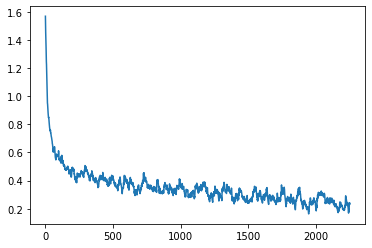

In [13]:
plt.plot(smooth(losses, .9))

### Train accuracy

In [14]:
compute_accuracy(train_dset)

0.9458333333333333

### Val accuracy

In [15]:
compute_accuracy(val_dset)

0.95

### Self-attention heatmap

In [16]:
alphas = np.zeros((6, 6))
for x, y in iter(tqdm(val_dset)):
    x_pe = x.float().unsqueeze(0) + model.pe
    q, k, v = model.mha.Qs[0](x_pe), model.mha.Ks[0](x_pe), model.mha.Vs[0](x_pe)
    alphas += alpha(q, k)[0].detach().numpy()

alphas /= len(val_dset)

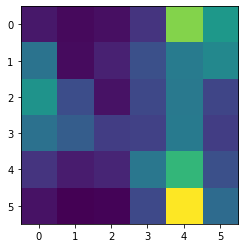

In [17]:
plt.imshow(alphas)